In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, recall_score, precision_score, f1_score
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt

In [9]:
validation_df = pd.read_csv('dataset_tratado/validation_df.csv')
train_df = pd.read_csv('dataset_tratado/train_df.csv')

In [10]:
train_df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction
0,-0.277804,-0.089306,-1.446976,-0.754370,-0.451942,-0.812200,0.026713,-0.568924,-0.797232,-1.436397,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,-0.216967,-1.004828,-1.446976,-2.083373,-1.279667,-0.812200,-1.460984,-1.438593,-1.564104,-1.436397,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,1.668967,-0.408911,1.656614,-0.754370,1.203508,0.852722,0.770562,1.170413,0.736513,0.832220,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,0.999764,1.976030,0.622084,1.239135,0.375783,0.020261,0.026713,0.300744,1.503385,0.832220,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,1.486457,-0.307045,-0.412446,-0.754370,-0.451942,0.852722,0.770562,-0.568924,0.736513,0.832220,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [14]:
X_train = train_df.drop(columns=['satisfaction']).values
y_train = train_df['satisfaction'].values

In [15]:
X_validation = validation_df.drop(columns=['satisfaction']).values
y_validation = validation_df['satisfaction'].values

## Transformando os dataframes en tensores

In [16]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)

In [17]:
test_input = torch.tensor(X_validation, dtype=torch.float32)
test_label = torch.tensor(y_validation, dtype=torch.long)

In [18]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

## Inicializando e treinando a rede KAN

In [19]:
model = KAN(width=[X_train.shape[1], 2], grid=3, k=3)

In [20]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [21]:
results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

train loss: 3.65e-01 | test loss: 3.84e-01 | reg: 7.24e+01 : 100%|██| 20/20 [06:24<00:00, 19.20s/it]


Visualizando o modelo

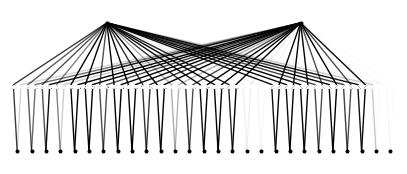

In [22]:
model.plot()

Resultados

In [23]:
# Obter a acurácia final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]

print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

Acurácia final no conjunto de treino: 0.9519
Acurácia final no conjunto de teste: 0.9462


In [37]:
# Calcular o MSE

test_outputs = model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

mse = mean_squared_error(y_validation, test_predictions)
print(f"MSE: {mse}")

MSE: 0.05378540305010893


In [41]:
# Calcular o Recall para o conjunto de teste
test_recall = recall_score(y_validation, test_predictions)
print("Test Recall:", test_recall)

Test Recall: 0.9512527233115469


In [43]:
# Calcular a Precision para o conjunto de teste
test_precision = precision_score(y_validation, test_predictions)
print("Test Precision:", test_precision)

Test Precision: 0.9417632785117283


In [44]:
# Calcular o F1-Score para o conjunto de teste
test_f1 = f1_score(y_validation, test_predictions)
print("Test F1-Score:", test_f1)

Test F1-Score: 0.946484216230863


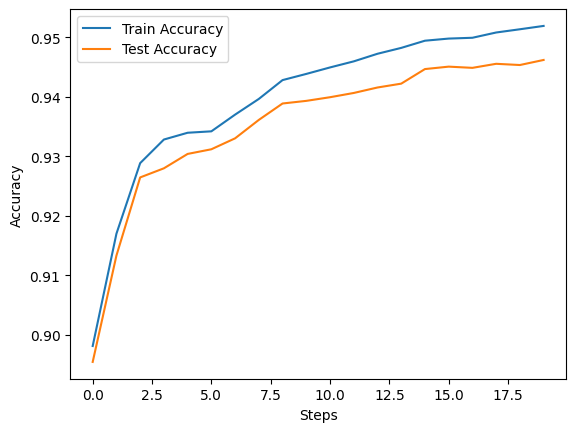

In [24]:
# Plotar os resultados de acurácia (opcional)
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

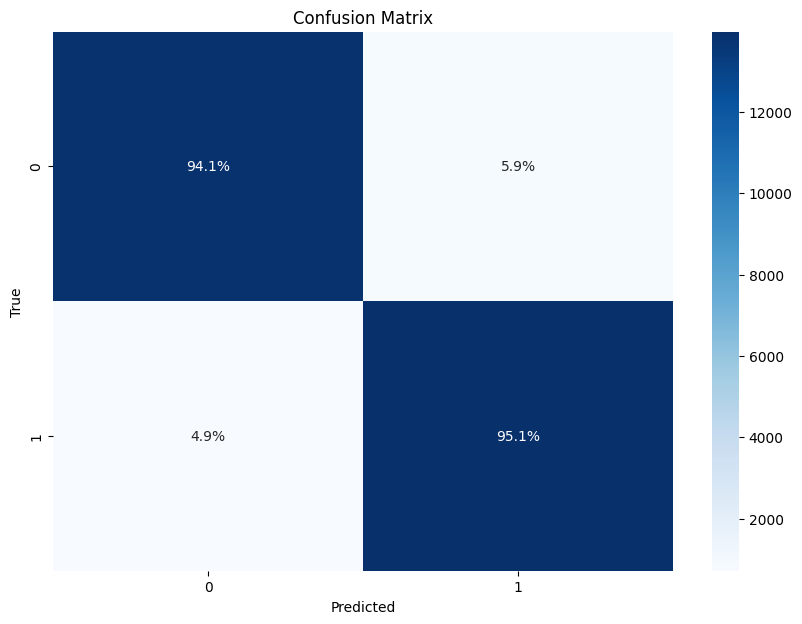

In [27]:
test_outputs = model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

conf_matrix = confusion_matrix(y_validation, test_predictions) # trocar por y_test
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

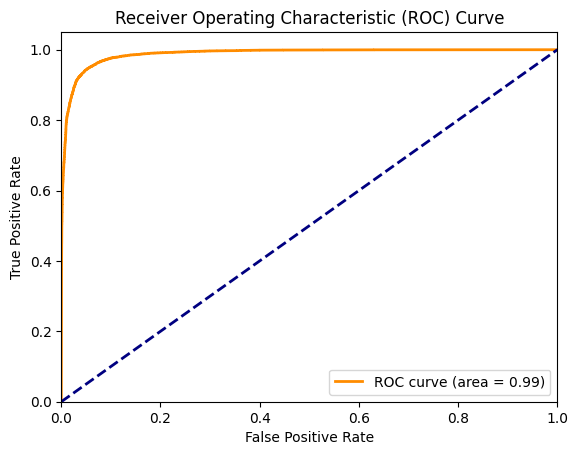

In [28]:
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_validation, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

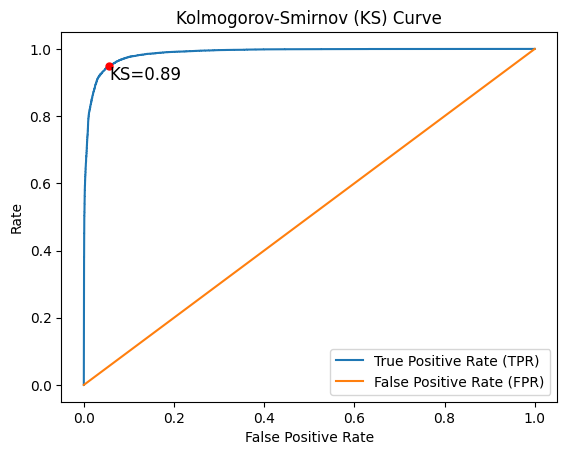

KS Statistic: 0.89


In [29]:
ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

## Grid Search

In [45]:
def train_and_evaluate_model(width, grid, k, steps, opt):
    model = KAN(width=width, grid=grid, k=k)

    # Funções de avaliação
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    results = model.train(dataset, opt=opt, steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    final_train_acc = results['train_acc'][-1]
    final_test_acc = results['test_acc'][-1]
    return final_train_acc, final_test_acc

Definindo a grade de busca

In [46]:
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [2, 3, 4],
    'k': [2, 3, 4],
    'steps': [10, 20, 30, 50, 100],
    'opt' : ['LBFGS', 'Adam']
}

In [48]:
best_params = None
best_accuracy = 0

# Iterar sobre todas as combinações de hiperparâmetros
for width in param_grid['width']:
    for grid in param_grid['grid']:
        for k in param_grid['k']:
            for opt in param_grid['opt']:
                for steps in param_grid['steps']:
                    train_acc, test_acc = train_and_evaluate_model(width, grid, k, steps, opt)
                    print(f"Width: {width}, Grid: {grid}, K: {k}, Steps: {steps}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
                    
                    if test_acc > best_accuracy:
                        best_accuracy = test_acc
                        best_params = {'width': width, 'grid': grid, 'k': k, 'steps': steps, 'opt':opt}

train loss: 4.73e-01 | test loss: 4.81e-01 | reg: 3.24e+01 : 100%|██| 10/10 [01:42<00:00, 10.22s/it]


Width: [27, 2], Grid: 2, K: 2, Steps: 10, Train Acc: 0.9169, Test Acc: 0.9137


train loss: 4.61e-01 | test loss: 4.67e-01 | reg: 4.93e+01 : 100%|██| 20/20 [03:27<00:00, 10.36s/it]


Width: [27, 2], Grid: 2, K: 2, Steps: 20, Train Acc: 0.9224, Test Acc: 0.9192


train loss: 4.45e-01 | test loss: 4.53e-01 | reg: 4.84e+01 : 100%|██| 30/30 [05:01<00:00, 10.06s/it]


Width: [27, 2], Grid: 2, K: 2, Steps: 30, Train Acc: 0.9245, Test Acc: 0.9217


train loss: 4.43e-01 | test loss: 4.52e-01 | reg: 6.68e+01 : 100%|██| 50/50 [08:20<00:00, 10.02s/it]


Width: [27, 2], Grid: 2, K: 2, Steps: 50, Train Acc: 0.9248, Test Acc: 0.9203


train loss: 4.36e-01 | test loss: 4.46e-01 | reg: 6.00e+01 : 100%|█| 100/100 [16:44<00:00, 10.04s/it


Width: [27, 2], Grid: 2, K: 2, Steps: 100, Train Acc: 0.9278, Test Acc: 0.9237


train loss: 1.70e+00 | test loss: 1.55e+00 | reg: 4.35e+01 : 100%|██| 10/10 [00:13<00:00,  1.40s/it]


Width: [27, 2], Grid: 2, K: 2, Steps: 10, Train Acc: 0.7705, Test Acc: 0.7699


train loss: 1.12e+00 | test loss: 1.03e+00 | reg: 4.42e+01 : 100%|██| 20/20 [00:22<00:00,  1.14s/it]


Width: [27, 2], Grid: 2, K: 2, Steps: 20, Train Acc: 0.8178, Test Acc: 0.8146


train loss: 8.71e-01 | test loss: 7.84e-01 | reg: 3.88e+01 : 100%|██| 30/30 [00:34<00:00,  1.15s/it]


Width: [27, 2], Grid: 2, K: 2, Steps: 30, Train Acc: 0.8381, Test Acc: 0.8348


train loss: 5.82e-01 | test loss: 6.17e-01 | reg: 3.46e+01 : 100%|██| 50/50 [00:57<00:00,  1.15s/it]


Width: [27, 2], Grid: 2, K: 2, Steps: 50, Train Acc: 0.8579, Test Acc: 0.8532


train loss: 5.64e-01 | test loss: 5.44e-01 | reg: 2.96e+01 : 100%|█| 100/100 [01:46<00:00,  1.07s/it


Width: [27, 2], Grid: 2, K: 2, Steps: 100, Train Acc: 0.8932, Test Acc: 0.8904


train loss: 4.24e-01 | test loss: 4.33e-01 | reg: 3.79e+01 : 100%|██| 10/10 [02:30<00:00, 15.04s/it]


Width: [27, 2], Grid: 2, K: 3, Steps: 10, Train Acc: 0.9312, Test Acc: 0.9281


train loss: 4.17e-01 | test loss: 4.28e-01 | reg: 3.86e+01 : 100%|██| 20/20 [05:01<00:00, 15.09s/it]


Width: [27, 2], Grid: 2, K: 3, Steps: 20, Train Acc: 0.9336, Test Acc: 0.9295


train loss: 4.00e-01 | test loss: 4.11e-01 | reg: 5.83e+01 : 100%|██| 30/30 [07:35<00:00, 15.17s/it]


Width: [27, 2], Grid: 2, K: 3, Steps: 30, Train Acc: 0.9401, Test Acc: 0.9357


train loss: 3.72e-01 | test loss: 3.83e-01 | reg: 1.07e+02 : 100%|██| 50/50 [12:46<00:00, 15.33s/it]


Width: [27, 2], Grid: 2, K: 3, Steps: 50, Train Acc: 0.9491, Test Acc: 0.9449


train loss: 3.53e-01 | test loss: 3.65e-01 | reg: 1.37e+02 : 100%|█| 100/100 [25:15<00:00, 15.15s/it


Width: [27, 2], Grid: 2, K: 3, Steps: 100, Train Acc: 0.9547, Test Acc: 0.9509


train loss: 1.23e+00 | test loss: 1.94e+00 | reg: 4.00e+01 : 100%|██| 10/10 [00:17<00:00,  1.80s/it]


Width: [27, 2], Grid: 2, K: 3, Steps: 10, Train Acc: 0.6105, Test Acc: 0.6100


train loss: 1.22e+00 | test loss: 1.01e+00 | reg: 4.11e+01 : 100%|██| 20/20 [00:36<00:00,  1.80s/it]


Width: [27, 2], Grid: 2, K: 3, Steps: 20, Train Acc: 0.8259, Test Acc: 0.8197


train loss: 6.76e-01 | test loss: 7.67e-01 | reg: 3.68e+01 : 100%|██| 30/30 [00:54<00:00,  1.81s/it]


Width: [27, 2], Grid: 2, K: 3, Steps: 30, Train Acc: 0.8204, Test Acc: 0.8161


train loss: 6.46e-01 | test loss: 5.69e-01 | reg: 3.31e+01 : 100%|██| 50/50 [01:30<00:00,  1.81s/it]


Width: [27, 2], Grid: 2, K: 3, Steps: 50, Train Acc: 0.8731, Test Acc: 0.8716


train loss: 4.65e-01 | test loss: 4.70e-01 | reg: 2.88e+01 : 100%|█| 100/100 [02:45<00:00,  1.65s/it


Width: [27, 2], Grid: 2, K: 3, Steps: 100, Train Acc: 0.9168, Test Acc: 0.9164


train loss: 4.65e-01 | test loss: 4.73e-01 | reg: 3.17e+01 : 100%|██| 10/10 [03:46<00:00, 22.64s/it]


Width: [27, 2], Grid: 2, K: 4, Steps: 10, Train Acc: 0.9184, Test Acc: 0.9157


train loss: 4.44e-01 | test loss: 4.51e-01 | reg: 5.78e+01 : 100%|██| 20/20 [07:32<00:00, 22.63s/it]


Width: [27, 2], Grid: 2, K: 4, Steps: 20, Train Acc: 0.9254, Test Acc: 0.9238


train loss: 4.64e-01 | test loss: 4.71e-01 | reg: 7.02e+01 : 100%|██| 30/30 [12:22<00:00, 24.76s/it]


Width: [27, 2], Grid: 2, K: 4, Steps: 30, Train Acc: 0.9167, Test Acc: 0.9128


train loss: 4.44e-01 | test loss: 4.52e-01 | reg: 1.28e+02 : 100%|██| 50/50 [19:29<00:00, 23.38s/it]


Width: [27, 2], Grid: 2, K: 4, Steps: 50, Train Acc: 0.9226, Test Acc: 0.9214


train loss: 3.71e-01 | test loss: 3.84e-01 | reg: 2.21e+02 : 100%|█| 100/100 [38:26<00:00, 23.07s/it


Width: [27, 2], Grid: 2, K: 4, Steps: 100, Train Acc: 0.9481, Test Acc: 0.9457


train loss: 2.17e+00 | test loss: 1.77e+00 | reg: 4.00e+01 : 100%|██| 10/10 [00:27<00:00,  2.80s/it]


Width: [27, 2], Grid: 2, K: 4, Steps: 10, Train Acc: 0.7296, Test Acc: 0.7273


train loss: 1.23e+00 | test loss: 1.13e+00 | reg: 3.50e+01 : 100%|██| 20/20 [00:55<00:00,  2.78s/it]


Width: [27, 2], Grid: 2, K: 4, Steps: 20, Train Acc: 0.8030, Test Acc: 0.8025


train loss: 8.21e-01 | test loss: 9.10e-01 | reg: 3.28e+01 : 100%|██| 30/30 [01:23<00:00,  2.78s/it]


Width: [27, 2], Grid: 2, K: 4, Steps: 30, Train Acc: 0.7860, Test Acc: 0.7817


train loss: 7.26e-01 | test loss: 6.04e-01 | reg: 3.05e+01 : 100%|██| 50/50 [02:18<00:00,  2.77s/it]


Width: [27, 2], Grid: 2, K: 4, Steps: 50, Train Acc: 0.8682, Test Acc: 0.8656


train loss: 5.11e-01 | test loss: 5.15e-01 | reg: 2.76e+01 : 100%|█| 100/100 [04:13<00:00,  2.54s/it


Width: [27, 2], Grid: 2, K: 4, Steps: 100, Train Acc: 0.8983, Test Acc: 0.8968


train loss: 3.72e-01 | test loss: 3.82e-01 | reg: 3.08e+01 : 100%|██| 10/10 [08:31<00:00, 51.18s/it]


Width: [27, 2], Grid: 3, K: 2, Steps: 10, Train Acc: 0.9497, Test Acc: 0.9468


train loss: 3.34e-01 | test loss: 3.48e-01 | reg: 5.41e+01 : 100%|██| 20/20 [03:54<00:00, 11.75s/it]


Width: [27, 2], Grid: 3, K: 2, Steps: 20, Train Acc: 0.9606, Test Acc: 0.9580


train loss: 3.23e-01 | test loss: 3.36e-01 | reg: 5.24e+01 : 100%|██| 30/30 [05:50<00:00, 11.69s/it]


Width: [27, 2], Grid: 3, K: 2, Steps: 30, Train Acc: 0.9644, Test Acc: 0.9615


train loss: 3.19e-01 | test loss: 3.34e-01 | reg: 5.17e+01 : 100%|██| 50/50 [09:35<00:00, 11.52s/it]


Width: [27, 2], Grid: 3, K: 2, Steps: 50, Train Acc: 0.9652, Test Acc: 0.9621


train loss: 3.07e-01 | test loss: 3.21e-01 | reg: 9.86e+01 : 100%|█| 100/100 [19:52<00:00, 11.93s/it


Width: [27, 2], Grid: 3, K: 2, Steps: 100, Train Acc: 0.9674, Test Acc: 0.9645


train loss: 1.33e+00 | test loss: 2.10e+00 | reg: 4.92e+01 : 100%|██| 10/10 [00:14<00:00,  1.41s/it]


Width: [27, 2], Grid: 3, K: 2, Steps: 10, Train Acc: 0.6108, Test Acc: 0.6116


train loss: 1.07e+00 | test loss: 1.03e+00 | reg: 4.30e+01 : 100%|██| 20/20 [00:27<00:00,  1.36s/it]


Width: [27, 2], Grid: 3, K: 2, Steps: 20, Train Acc: 0.8442, Test Acc: 0.8429


train loss: 7.69e-01 | test loss: 6.63e-01 | reg: 3.78e+01 : 100%|██| 30/30 [00:40<00:00,  1.36s/it]


Width: [27, 2], Grid: 3, K: 2, Steps: 30, Train Acc: 0.8897, Test Acc: 0.8862


train loss: 4.63e-01 | test loss: 4.78e-01 | reg: 3.47e+01 : 100%|██| 50/50 [01:09<00:00,  1.39s/it]


Width: [27, 2], Grid: 3, K: 2, Steps: 50, Train Acc: 0.9205, Test Acc: 0.9165


train loss: 4.01e-01 | test loss: 4.08e-01 | reg: 3.31e+01 : 100%|█| 100/100 [02:12<00:00,  1.32s/it


Width: [27, 2], Grid: 3, K: 2, Steps: 100, Train Acc: 0.9397, Test Acc: 0.9374


train loss: 3.88e-01 | test loss: 4.00e-01 | reg: 3.13e+01 : 100%|██| 10/10 [03:05<00:00, 18.51s/it]


Width: [27, 2], Grid: 3, K: 3, Steps: 10, Train Acc: 0.9434, Test Acc: 0.9391


train loss: 3.65e-01 | test loss: 3.82e-01 | reg: 5.45e+01 : 100%|██| 20/20 [06:13<00:00, 18.65s/it]


Width: [27, 2], Grid: 3, K: 3, Steps: 20, Train Acc: 0.9512, Test Acc: 0.9462


train loss: 3.48e-01 | test loss: 3.76e-01 | reg: 1.31e+02 : 100%|██| 30/30 [08:38<00:00, 17.27s/it]


Width: [27, 2], Grid: 3, K: 3, Steps: 30, Train Acc: 0.9590, Test Acc: 0.9548


train loss: 3.33e-01 | test loss: 3.59e-01 | reg: 1.47e+02 : 100%|██| 50/50 [14:50<00:00, 17.82s/it]


Width: [27, 2], Grid: 3, K: 3, Steps: 50, Train Acc: 0.9621, Test Acc: 0.9581


train loss: 2.82e-01 | test loss: 3.03e-01 | reg: 2.84e+02 : 100%|█| 100/100 [29:14<00:00, 17.54s/it


Width: [27, 2], Grid: 3, K: 3, Steps: 100, Train Acc: 0.9728, Test Acc: 0.9699


train loss: 1.83e+00 | test loss: 1.63e+00 | reg: 5.30e+01 : 100%|██| 10/10 [00:21<00:00,  2.11s/it]


Width: [27, 2], Grid: 3, K: 3, Steps: 10, Train Acc: 0.7719, Test Acc: 0.7711


train loss: 1.45e+00 | test loss: 1.18e+00 | reg: 4.36e+01 : 100%|██| 20/20 [00:41<00:00,  2.09s/it]


Width: [27, 2], Grid: 3, K: 3, Steps: 20, Train Acc: 0.8484, Test Acc: 0.8434


train loss: 9.82e-01 | test loss: 9.43e-01 | reg: 3.61e+01 : 100%|██| 30/30 [01:02<00:00,  2.09s/it]


Width: [27, 2], Grid: 3, K: 3, Steps: 30, Train Acc: 0.8205, Test Acc: 0.8194


train loss: 5.75e-01 | test loss: 6.10e-01 | reg: 3.34e+01 : 100%|██| 50/50 [01:46<00:00,  2.13s/it]


Width: [27, 2], Grid: 3, K: 3, Steps: 50, Train Acc: 0.8838, Test Acc: 0.8794


train loss: 4.32e-01 | test loss: 4.40e-01 | reg: 2.92e+01 : 100%|█| 100/100 [03:33<00:00,  2.14s/it


Width: [27, 2], Grid: 3, K: 3, Steps: 100, Train Acc: 0.9299, Test Acc: 0.9248


train loss: 3.86e-01 | test loss: 3.96e-01 | reg: 3.01e+01 : 100%|██| 10/10 [04:41<00:00, 28.17s/it]


Width: [27, 2], Grid: 3, K: 4, Steps: 10, Train Acc: 0.9448, Test Acc: 0.9416


train loss: 4.20e-01 | test loss: 4.31e-01 | reg: 3.00e+01 : 100%|██| 20/20 [09:29<00:00, 28.45s/it]


Width: [27, 2], Grid: 3, K: 4, Steps: 20, Train Acc: 0.9323, Test Acc: 0.9288


train loss: 4.04e-01 | test loss: 4.17e-01 | reg: 3.35e+01 : 100%|██| 30/30 [13:48<00:00, 27.61s/it]


Width: [27, 2], Grid: 3, K: 4, Steps: 30, Train Acc: 0.9383, Test Acc: 0.9343


train loss: 4.18e-01 | test loss: 4.30e-01 | reg: 4.19e+01 : 100%|██| 50/50 [23:11<00:00, 27.83s/it]


Width: [27, 2], Grid: 3, K: 4, Steps: 50, Train Acc: 0.9350, Test Acc: 0.9300


train loss: 3.08e-01 | test loss: 3.24e-01 | reg: 9.12e+01 : 100%|█| 100/100 [48:24<00:00, 29.05s/it


Width: [27, 2], Grid: 3, K: 4, Steps: 100, Train Acc: 0.9652, Test Acc: 0.9614


train loss: 2.56e+00 | test loss: 2.28e+00 | reg: 5.36e+01 : 100%|██| 10/10 [00:34<00:00,  3.42s/it]


Width: [27, 2], Grid: 3, K: 4, Steps: 10, Train Acc: 0.5592, Test Acc: 0.5597


train loss: 1.27e+00 | test loss: 1.14e+00 | reg: 5.34e+01 : 100%|██| 20/20 [01:11<00:00,  3.55s/it]


Width: [27, 2], Grid: 3, K: 4, Steps: 20, Train Acc: 0.8580, Test Acc: 0.8560


train loss: 8.74e-01 | test loss: 7.84e-01 | reg: 4.41e+01 : 100%|██| 30/30 [01:43<00:00,  3.45s/it]


Width: [27, 2], Grid: 3, K: 4, Steps: 30, Train Acc: 0.8659, Test Acc: 0.8624


train loss: 5.85e-01 | test loss: 5.96e-01 | reg: 4.24e+01 : 100%|██| 50/50 [02:57<00:00,  3.54s/it]


Width: [27, 2], Grid: 3, K: 4, Steps: 50, Train Acc: 0.8805, Test Acc: 0.8764


train loss: 5.08e-01 | test loss: 4.74e-01 | reg: 3.63e+01 : 100%|█| 100/100 [05:37<00:00,  3.38s/it


Width: [27, 2], Grid: 3, K: 4, Steps: 100, Train Acc: 0.9166, Test Acc: 0.9138


train loss: 3.33e-01 | test loss: 3.51e-01 | reg: 4.01e+01 : 100%|██| 10/10 [02:33<00:00, 15.38s/it]


Width: [27, 2], Grid: 4, K: 2, Steps: 10, Train Acc: 0.9602, Test Acc: 0.9551


train loss: 3.01e-01 | test loss: 3.13e-01 | reg: 9.21e+01 : 100%|██| 20/20 [05:02<00:00, 15.14s/it]


Width: [27, 2], Grid: 4, K: 2, Steps: 20, Train Acc: 0.9691, Test Acc: 0.9669


train loss: 2.90e-01 | test loss: 2.99e-01 | reg: 1.21e+02 : 100%|██| 30/30 [06:35<00:00, 13.19s/it]


Width: [27, 2], Grid: 4, K: 2, Steps: 30, Train Acc: 0.9716, Test Acc: 0.9701


train loss: 2.87e-01 | test loss: 2.97e-01 | reg: 1.29e+02 : 100%|██| 50/50 [10:52<00:00, 13.05s/it]


Width: [27, 2], Grid: 4, K: 2, Steps: 50, Train Acc: 0.9716, Test Acc: 0.9697


train loss: 2.85e-01 | test loss: 2.96e-01 | reg: 1.42e+02 : 100%|█| 100/100 [22:04<00:00, 13.24s/it


Width: [27, 2], Grid: 4, K: 2, Steps: 100, Train Acc: 0.9713, Test Acc: 0.9691


train loss: 1.10e+00 | test loss: 2.07e+00 | reg: 4.94e+01 : 100%|██| 10/10 [00:15<00:00,  1.57s/it]


Width: [27, 2], Grid: 4, K: 2, Steps: 10, Train Acc: 0.6404, Test Acc: 0.6401


train loss: 1.08e+00 | test loss: 8.77e-01 | reg: 4.91e+01 : 100%|██| 20/20 [00:31<00:00,  1.56s/it]


Width: [27, 2], Grid: 4, K: 2, Steps: 20, Train Acc: 0.9106, Test Acc: 0.9097


train loss: 6.68e-01 | test loss: 8.06e-01 | reg: 3.96e+01 : 100%|██| 30/30 [00:46<00:00,  1.55s/it]


Width: [27, 2], Grid: 4, K: 2, Steps: 30, Train Acc: 0.8936, Test Acc: 0.8896


train loss: 4.77e-01 | test loss: 4.49e-01 | reg: 3.56e+01 : 100%|██| 50/50 [01:18<00:00,  1.56s/it]


Width: [27, 2], Grid: 4, K: 2, Steps: 50, Train Acc: 0.9359, Test Acc: 0.9317


train loss: 3.53e-01 | test loss: 3.66e-01 | reg: 3.38e+01 : 100%|█| 100/100 [02:24<00:00,  1.45s/it


Width: [27, 2], Grid: 4, K: 2, Steps: 100, Train Acc: 0.9555, Test Acc: 0.9513


train loss: 3.26e-01 | test loss: 3.42e-01 | reg: 2.66e+01 : 100%|██| 10/10 [03:17<00:00, 19.74s/it]


Width: [27, 2], Grid: 4, K: 3, Steps: 10, Train Acc: 0.9607, Test Acc: 0.9573


train loss: 3.20e-01 | test loss: 3.38e-01 | reg: 2.93e+01 : 100%|██| 20/20 [06:53<00:00, 20.66s/it]


Width: [27, 2], Grid: 4, K: 3, Steps: 20, Train Acc: 0.9624, Test Acc: 0.9579


train loss: 2.93e-01 | test loss: 3.07e-01 | reg: 7.42e+01 : 100%|██| 30/30 [10:28<00:00, 20.94s/it]


Width: [27, 2], Grid: 4, K: 3, Steps: 30, Train Acc: 0.9685, Test Acc: 0.9658


train loss: 2.87e-01 | test loss: 2.99e-01 | reg: 7.60e+01 : 100%|██| 50/50 [17:40<00:00, 21.21s/it]


Width: [27, 2], Grid: 4, K: 3, Steps: 50, Train Acc: 0.9698, Test Acc: 0.9677


train loss: 2.56e-01 | test loss: 2.65e-01 | reg: 9.94e+01 : 100%|█| 100/100 [34:56<00:00, 20.97s/it


Width: [27, 2], Grid: 4, K: 3, Steps: 100, Train Acc: 0.9767, Test Acc: 0.9758


train loss: 1.29e+00 | test loss: 2.10e+00 | reg: 4.94e+01 : 100%|██| 10/10 [00:25<00:00,  2.52s/it]


Width: [27, 2], Grid: 4, K: 3, Steps: 10, Train Acc: 0.6194, Test Acc: 0.6237


train loss: 9.02e-01 | test loss: 1.02e+00 | reg: 4.55e+01 : 100%|██| 20/20 [00:50<00:00,  2.50s/it]


Width: [27, 2], Grid: 4, K: 3, Steps: 20, Train Acc: 0.8417, Test Acc: 0.8427


train loss: 6.78e-01 | test loss: 7.03e-01 | reg: 3.90e+01 : 100%|██| 30/30 [01:15<00:00,  2.50s/it]


Width: [27, 2], Grid: 4, K: 3, Steps: 30, Train Acc: 0.8962, Test Acc: 0.8919


train loss: 6.17e-01 | test loss: 7.11e-01 | reg: 3.56e+01 : 100%|██| 50/50 [02:06<00:00,  2.52s/it]


Width: [27, 2], Grid: 4, K: 3, Steps: 50, Train Acc: 0.8221, Test Acc: 0.8194


train loss: 3.66e-01 | test loss: 3.75e-01 | reg: 3.09e+01 : 100%|█| 100/100 [03:48<00:00,  2.29s/it


Width: [27, 2], Grid: 4, K: 3, Steps: 100, Train Acc: 0.9532, Test Acc: 0.9479


train loss: 4.03e-01 | test loss: 4.17e-01 | reg: 2.77e+01 : 100%|██| 10/10 [05:05<00:00, 30.57s/it]


Width: [27, 2], Grid: 4, K: 4, Steps: 10, Train Acc: 0.9389, Test Acc: 0.9329


train loss: 4.10e-01 | test loss: 4.21e-01 | reg: 2.91e+01 : 100%|██| 20/20 [10:13<00:00, 30.68s/it]


Width: [27, 2], Grid: 4, K: 4, Steps: 20, Train Acc: 0.9365, Test Acc: 0.9312


train loss: 3.93e-01 | test loss: 4.09e-01 | reg: 3.82e+01 : 100%|██| 30/30 [15:27<00:00, 30.91s/it]


Width: [27, 2], Grid: 4, K: 4, Steps: 30, Train Acc: 0.9416, Test Acc: 0.9390


train loss: 3.46e-01 | test loss: 3.61e-01 | reg: 5.62e+01 : 100%|██| 50/50 [25:49<00:00, 30.99s/it]


Width: [27, 2], Grid: 4, K: 4, Steps: 50, Train Acc: 0.9560, Test Acc: 0.9513


train loss: 2.34e-01 | test loss: 2.47e-01 | reg: 9.30e+01 : 100%|█| 100/100 [1:25:43<00:00, 51.43s/


Width: [27, 2], Grid: 4, K: 4, Steps: 100, Train Acc: 0.9802, Test Acc: 0.9793


train loss: 1.20e+00 | test loss: 2.00e+00 | reg: 4.59e+01 : 100%|██| 10/10 [00:43<00:00,  4.37s/it]


Width: [27, 2], Grid: 4, K: 4, Steps: 10, Train Acc: 0.6020, Test Acc: 0.6016


train loss: 1.29e+00 | test loss: 1.13e+00 | reg: 4.42e+01 : 100%|██| 20/20 [01:25<00:00,  4.29s/it]


Width: [27, 2], Grid: 4, K: 4, Steps: 20, Train Acc: 0.8333, Test Acc: 0.8333


train loss: 1.17e+00 | test loss: 1.06e+00 | reg: 3.69e+01 : 100%|██| 30/30 [02:08<00:00,  4.29s/it]


Width: [27, 2], Grid: 4, K: 4, Steps: 30, Train Acc: 0.8329, Test Acc: 0.8297


train loss: 5.93e-01 | test loss: 5.87e-01 | reg: 2.91e+01 : 100%|██| 50/50 [03:16<00:00,  3.92s/it]


Width: [27, 2], Grid: 4, K: 4, Steps: 50, Train Acc: 0.8783, Test Acc: 0.8746


train loss: 4.16e-01 | test loss: 4.26e-01 | reg: 3.26e+01 : 100%|█| 100/100 [06:26<00:00,  3.87s/it

Width: [27, 2], Grid: 4, K: 4, Steps: 100, Train Acc: 0.9349, Test Acc: 0.9309


Analise da combinação de parâmetros escolhida

In [49]:
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy:.4f}")

Best parameters: {'width': [27, 2], 'grid': 4, 'k': 4, 'steps': 100, 'opt': 'LBFGS'}
Best test accuracy: 0.9793


Treinamento com os parametros escolhidos no Grid Search

In [52]:
final_model = KAN(width=best_params['width'], grid=best_params['grid'], k=best_params['k'])


In [55]:
# Funções de avaliação
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = final_model.train(dataset, opt=best_params['opt'], steps=best_params['steps'], metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())










































































































































































































train loss: 2.27e-01 | test loss: 2.42e-01 | reg: 1.15e+02 : 100%|█| 100/100 [55:31<00:00, 33.31s/it


Avaliação do modelo treinado

description:   0%|                                                        | 0/100 [1:18:54<?, ?it/s]


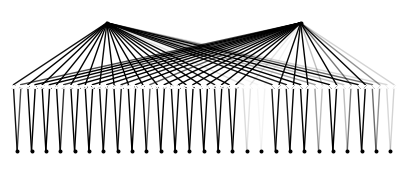

In [56]:
final_model.plot()

In [57]:
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]

print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

Acurácia final no conjunto de treino: 0.9519
Acurácia final no conjunto de teste: 0.9462


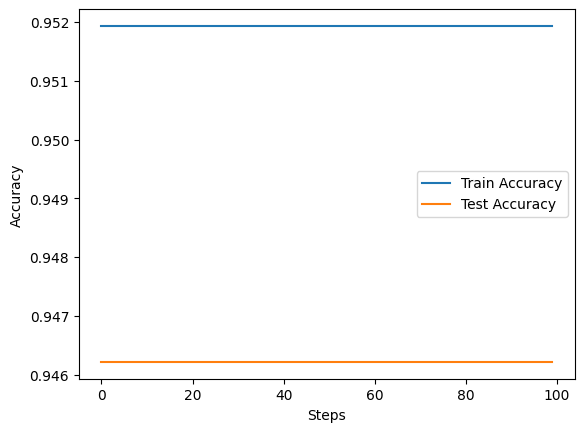

In [58]:
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
# Calcular o MSE

test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

mse = mean_squared_error(y_validation, test_predictions)
print(f"MSE: {mse}")

MSE: 0.020322712418300654


In [60]:
# Calcular o Recall para o conjunto de teste
test_recall = recall_score(y_validation, test_predictions)
print("Test Recall:", test_recall)

Test Recall: 0.9822984749455338


In [61]:
# Calcular a Precision para o conjunto de teste
test_precision = precision_score(y_validation, test_predictions)
print("Test Precision:", test_precision)

Test Precision: 0.9771757534710463


In [62]:
# Calcular o F1-Score para o conjunto de teste
test_f1 = f1_score(y_validation, test_predictions)
print("Test F1-Score:", test_f1)

Test F1-Score: 0.9797304179540286


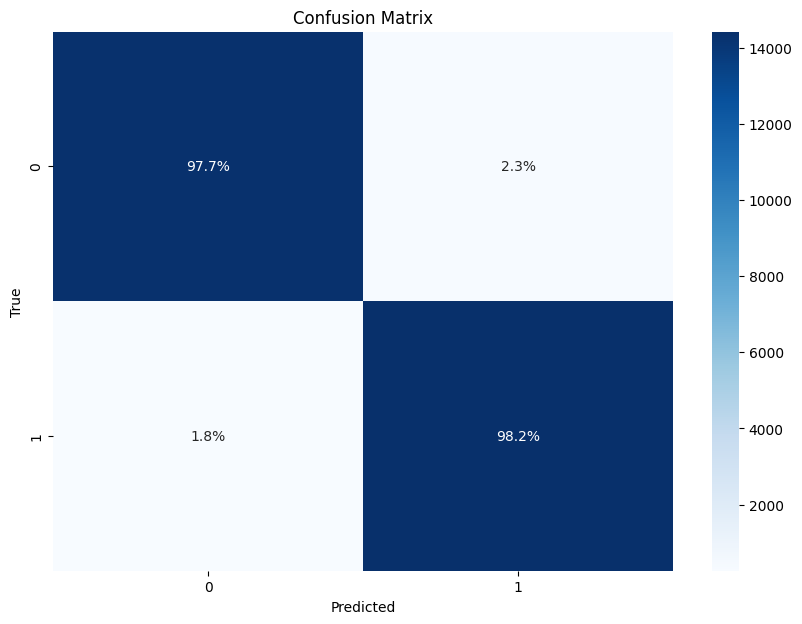

In [63]:
test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

conf_matrix = confusion_matrix(y_validation, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

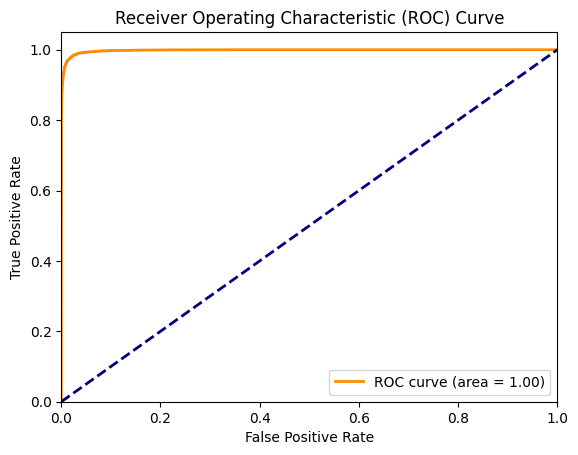

In [64]:
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_validation, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

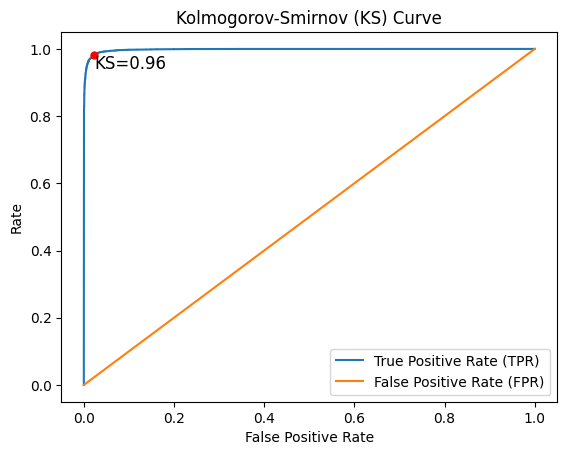

KS Statistic: 0.96


In [65]:
ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")